### Import Library

In [ ]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import string
import re
import nltk
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
import pickle
import requests
import json
from sklearn.svm import SVC

In [2]:
nltk.download('punkt', force=True)
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ejaad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejaad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Preprocessing data

In [3]:
# Load data ulasan
data = pd.read_csv("magic_chess_reviews.csv")

In [ ]:
# Cek data frame
df = pd.DataFrame(data)
df.shape
df.head()

In [5]:
# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = df.shape

In [ ]:
# Hapus missing value
clean_df = df.dropna()

# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

### Preprocessing teks

In [161]:
# Inisialisasi stemmer bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [8]:
# Load stopwords bahasa Indonesia & Inggris
stop_words = set(stopwords.words('indonesian'))
stop_words.update(stopwords.words('english'))
stop_words.update(['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy'])


In [9]:
# Daftar kata sentimen
positive_words = set(["baik", "bagus", "mantap", "senang", "puas", "suka", "hebat", "luar biasa", "terbaik"])
negative_words = set(["buruk", "jelek", "kecewa", "parah", "lambat", "tidak suka", "mengecewakan", "payah", "bug"]) 


In [ ]:
# Preprocessing teks
def preprocess_text(text):
    # Pastikan teks adalah string
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Lowercasing
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag
    text = re.sub(r'RT[\s]', '', text)  # Menghapus RT
    text = re.sub(r'http\S+', '', text)  # Menghapus URL/link
    text = re.sub(r'[0-9]+', '', text)  # Menghapus angka
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Menghapus karakter selain huruf dan spasi
    text = text.replace('\n', ' ')  # Mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    text = text.strip()  # Menghapus spasi di awal dan akhir
    
    tokens = re.findall(r'\b\w+\b', text)  # Tokenization dengan regex
    tokens = [word for word in tokens if word not in stop_words]  # Stopword removal
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    return " ".join(tokens)

def label_sentiment(text):
    words = set(text.split())
    pos_count = len(words & positive_words)
    neg_count = len(words & negative_words)
    
    if pos_count > neg_count:
        return 1  # Positif
    elif neg_count > pos_count:
        return -1  # Negatif
    else:
        return 0  # Netral

# Terapkan preprocessing ke setiap ulasan
if 'content' in df.columns:
    df['clean_content'] = df['content'].apply(preprocess_text)
    df['sentiment'] = df['clean_content'].apply(label_sentiment)
    
    # Simpan hasil preprocessing dan labeling
    processed_filename = "magic_chess_reviews_clean.csv"
    df[['clean_content', 'score', 'sentiment']].to_csv(processed_filename, index=False)
    print(f"Preprocessing dan labeling selesai. Data disimpan dalam {processed_filename}")
else:
    print("Kolom 'content' tidak ditemukan dalam data.")



Preprocessing dan labeling selesai. Data disimpan dalam magic_chess_reviews_clean.csv


## Analisis sentimen

C:\Users\ejaad\AppData\Local\Temp\ipykernel_10972\3581007145.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'].map({-1: "Negatif", 0: "Netral", 1: "Positif"}), palette='coolwarm')


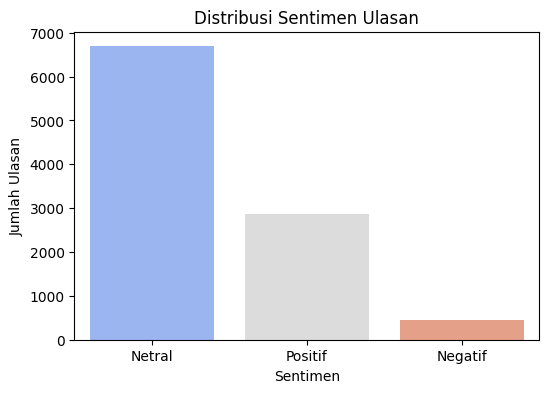

In [13]:
# Analisis Sentimen
plt.figure(figsize=(6, 4))
sns.countplot(x=df['sentiment'].map({-1: "Negatif", 0: "Netral", 1: "Positif"}), palette='coolwarm')
plt.title("Distribusi Sentimen Ulasan")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.show()

C:\Users\ejaad\AppData\Local\Temp\ipykernel_10972\4144550406.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


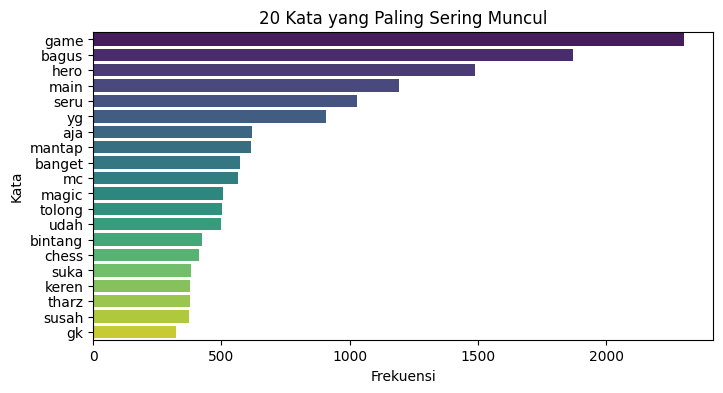

In [ ]:

# Analisis Kata Kunci
all_words = " ".join(df['clean_content']).split()
common_words = Counter(all_words).most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title("20 Kata yang Paling Sering Muncul")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()

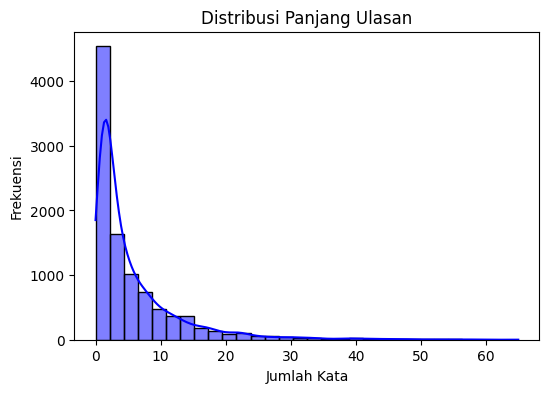

In [16]:
# Distribusi Panjang Teks
df['text_length'] = df['clean_content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 4))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.title("Distribusi Panjang Ulasan")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()


C:\Users\ejaad\AppData\Local\Temp\ipykernel_10972\1723424477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['score'], y=df['sentiment'], palette='coolwarm')


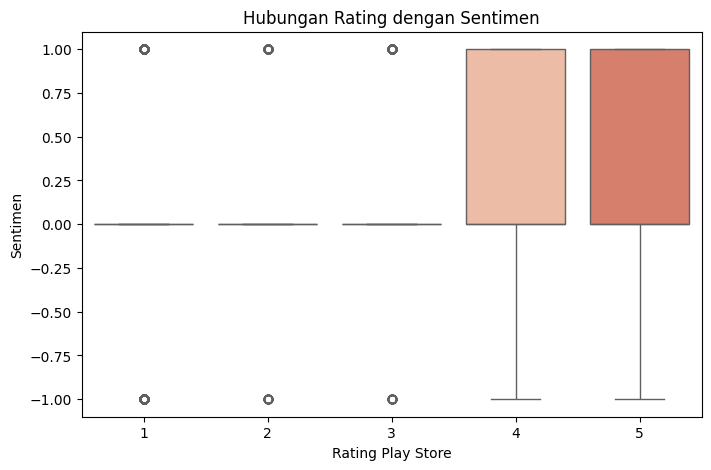

In [17]:
# Analisis Rating vs Sentimen
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['score'], y=df['sentiment'], palette='coolwarm')
plt.title("Hubungan Rating dengan Sentimen")
plt.xlabel("Rating Play Store")
plt.ylabel("Sentimen")
plt.show()

## Modeling menggunakan LSTM

In [25]:
# Memuat data hasil preprocessing
df = pd.read_csv("magic_chess_reviews_clean.csv")

# Pilih teks dan label sentimen
X_text = df['clean_content']
y = df['sentiment']

# Hapus baris yang memiliki NaN pada teks
df = df.dropna(subset=['clean_content'])

# Atau, ganti NaN dengan string kosong
df['clean_content'] = df['clean_content'].fillna("")


In [ ]:
X_text = df['clean_content'].astype(str)

print("Jumlah data kosong sebelum pemrosesan:", df['clean_content'].isna().sum())
print(df.head())  # Untuk melihat apakah ada data aneh

Jumlah data kosong sebelum pemrosesan: 0
                                       clean_content  score  sentiment
0                                    seru main geram      5          0
1                                           far good      5          0
2  gamenya bagus cuman gacha hero lumayan susah cari      4          1
3                                   game seru banget      5          0
4                                             mantap      5          1


In [28]:
X_text = df['clean_content'].astype(str).tolist()
y = df['sentiment'].values  


In [29]:
print("Jumlah data kosong setelah konversi:", sum(pd.Series(X_text).isna()))
print("Contoh data:", X_text[:5])


Jumlah data kosong setelah konversi: 0
Contoh data: ['seru main geram', 'far good', 'gamenya bagus cuman gacha hero lumayan susah cari', 'game seru banget', 'mantap']


In [163]:
# ==================== TF-IDF + SVM (80/20) ====================
print("\nModel: SVM + TF-IDF (80/20)")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# Membagi data latih dan data uji (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Melatih model SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

y_train_svm = svm_model.predict(X_train)
print("Akurasi Pelatihan:", accuracy_score(y_train, y_train_svm))

# Evaluasi model
y_pred_svm = svm_model.predict(X_test)

print("Akurasi Pengujian:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))




Model: SVM + TF-IDF (80/20)
Akurasi Pelatihan: 0.9945160056115292
Akurasi Pengujian: 0.9775624681285059
              precision    recall  f1-score   support

          -1       0.99      0.73      0.84       111
           0       0.97      1.00      0.98      1262
           1       1.00      0.98      0.99       588

    accuracy                           0.98      1961
   macro avg       0.98      0.90      0.94      1961
weighted avg       0.98      0.98      0.98      1961



In [164]:
print(f"Jumlah fitur yang diharapkan oleh RF: {svm_model.n_features_in_}")

Jumlah fitur yang diharapkan oleh RF: 5000


In [162]:
# ==================== Word2Vec + RF (80/20) ====================
print("\nModel: RF + Word2Vec (80/20)")
tokenized_text = [text.split() for text in X_text]
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4)
word_vectors = w2v_model.wv

def text_to_w2v(text):
    words = text.split()
    words = [word for word in words if word in word_vectors]
    if len(words) == 0:
        return np.zeros(100)
    return np.mean([word_vectors[word] for word in words], axis=0)

X_w2v = np.array([text_to_w2v(text) for text in X_text])

X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_train_rf_w2v = rf_model.predict(X_train)
print("Akurasi Pelatihan:", accuracy_score(y_train, y_train_rf_w2v))

y_pred_rf_w2v = rf_model.predict(X_test)
print("Akurasi Pengujian:", accuracy_score(y_test, y_pred_rf_w2v))
print(classification_report(y_test, y_pred_rf_w2v))


Model: RF + Word2Vec (80/20)
Akurasi Pelatihan: 1.0
Akurasi Pengujian: 0.8378378378378378
              precision    recall  f1-score   support

          -1       1.00      0.14      0.24       111
           0       0.81      0.98      0.89      1262
           1       0.94      0.66      0.77       588

    accuracy                           0.84      1961
   macro avg       0.92      0.59      0.63      1961
weighted avg       0.86      0.84      0.82      1961



In [157]:
# ==================== TF-IDF + RF (70/30) ====================
print("\nModel: RF + TF-IDF (70/30)")
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

rf_model_tfidf = RandomForestClassifier(n_estimators=200, min_samples_split=5,random_state=42)
rf_model_tfidf.fit(X_train, y_train)

y_train_rf_tfidf = rf_model_tfidf.predict(X_train)
print("Akurasi Pelatihan:", accuracy_score(y_train, y_train_rf_tfidf))

y_pred_rf_tfidf = rf_model_tfidf.predict(X_test)
print("Akurasi Pengujian:", accuracy_score(y_test, y_pred_rf_tfidf))
print(classification_report(y_test, y_pred_rf_tfidf))


Model: RF + TF-IDF (70/30)
Akurasi Pelatihan: 1.0
Akurasi Pengujian: 0.9785787147228834
              precision    recall  f1-score   support

          -1       0.97      0.77      0.86       145
           0       0.98      0.99      0.98      1902
           1       0.98      0.99      0.99       894

    accuracy                           0.98      2941
   macro avg       0.98      0.91      0.94      2941
weighted avg       0.98      0.98      0.98      2941



In [146]:
print(f"Jumlah fitur saat training: {X_tfidf.shape[1]}")  # X_tfidf dari training


Jumlah fitur saat training: 5000


In [147]:
print(f"Jumlah fitur yang diharapkan oleh RF: {rf_model_tfidf.n_features_in_}")

Jumlah fitur yang diharapkan oleh RF: 5000


# Inference model

In [165]:
# Simpan Model Random Forest
with open("rf_model_tfidf.pkl", "wb") as model_file:
    pickle.dump(rf_model_tfidf, model_file)

# simpan model svm
with open("svm_model_tfidf.pkl", "wb") as model_file:
    pickle.dump(svm_model, model_file)

# Simpan TF-IDF Vectorizer setelah training
with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(tfidf_vectorizer, file)

print("Model dan vectorizer berhasil disimpan!")


Model dan vectorizer berhasil disimpan!


In [168]:
# ====== Load Model & TF-IDF Vectorizer ======
with open("rf_model_tfidf.pkl", "rb") as model_file:
    rf_model_tfidf = pickle.load(model_file)
    
# ====== Load Model & TF-IDF Vectorizer ======
with open("svm_model_tfidf.pkl", "rb") as model_file:
    svm_model_tfidf = pickle.load(model_file)

# Load kembali TF-IDF Vectorizer dari file
with open("tfidf_vectorizer.pkl", "rb") as file:
    tfidf_vectorizer = pickle.load(file)


In [169]:
review_tfidf = tfidf_vectorizer.transform(["Game ini seru!"])
print(f"Jumlah fitur saat inference: {review_tfidf.shape[1]}")  # Harus sama dengan training
print(f"Jumlah fitur yang diharapkan oleh RF: {rf_model_tfidf.n_features_in_}")
print(f"Jumlah fitur yang diharapkan oleh RF: {svm_model_tfidf.n_features_in_}")

Jumlah fitur saat inference: 5000
Jumlah fitur yang diharapkan oleh RF: 5000
Jumlah fitur yang diharapkan oleh RF: 5000


In [172]:
# ====== Load Stopwords & Stemmer ======
# URL stopwords dari GitHub
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-id/master/stopwords-id.json"

# Mengambil data stopwords dari GitHub
response = requests.get(url)
stopwords_indonesia = set(json.loads(response.text))

# ====== Preprocessing Function ======
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()  # Lowercasing
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove links
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stopwords_indonesia])  # Stemming & Stopwords
    return text

# ====== Mapping Sentimen ======
sentiment_mapping = {-1: "Negatif", 0: "Netral", 1: "Positif"}

# ====== Inference Function Menggunakan Model RF ======
def predict_sentiment(review):
    # Preprocessing teks
    clean_review = preprocess_text(review)

    # Gunakan TF-IDF Vectorizer yang sudah dipakai saat training
    review_tfidf = tfidf_vectorizer.transform([clean_review])

    # Prediksi menggunakan model yang sudah dilatih
    sentiment_label = rf_model_tfidf.predict(review_tfidf)[0]

    return sentiment_mapping[sentiment_label]


# ====== Contoh Testing ======
if __name__ == "__main__":
    test_reviews = [
        "Game ini sangat menyenangkan dan seru!",
        "Grafik bagus tapi banyak bug yang mengganggu.",
        "Aduh, kecewa banget dengan update terbaru.",
        "Lumayanlah, gak terlalu buruk.",
        "cukup baik",
        "kurang baik",
        "jujur ini buruk",
        "jujur ini baik",
        "lumayanlah"
    ]

    for review in test_reviews:
        print(f"Review: {review} -> Sentimen: {predict_sentiment(review)}")


Review: Game ini sangat menyenangkan dan seru! -> Sentimen: Positif
Review: Grafik bagus tapi banyak bug yang mengganggu. -> Sentimen: Netral
Review: Aduh, kecewa banget dengan update terbaru. -> Sentimen: Negatif
Review: Lumayanlah, gak terlalu buruk. -> Sentimen: Negatif
Review: cukup baik -> Sentimen: Netral
Review: kurang baik -> Sentimen: Netral
Review: jujur ini buruk -> Sentimen: Negatif
Review: jujur ini baik -> Sentimen: Netral
Review: lumayanlah -> Sentimen: Netral


In [171]:
#  ====== Inference Function Menggunakan Model SVM ======
def predict_sentiment(review):
    # Preprocessing teks
    clean_review = preprocess_text(review)

    # Gunakan TF-IDF Vectorizer yang sudah dipakai saat training
    review_tfidf = tfidf_vectorizer.transform([clean_review])

    # Prediksi menggunakan model yang sudah dilatih
    sentiment_label = svm_model_tfidf.predict(review_tfidf)[0]

    return sentiment_mapping[sentiment_label]


# ====== Contoh Testing ======
if __name__ == "__main__":
    test_reviews = [
        "Game ini sangat menyenangkan dan seru!",
        "Grafik bagus tapi banyak bug yang mengganggu.",
        "Aduh, kecewa banget dengan update terbaru.",
        "Lumayanlah, gak terlalu buruk.",
        "cukup baik",
        "kurang baik",
        "jujur ini buruk",
        "jujur ini baik",
        "lumayanlah"
    ]

    for review in test_reviews:
        print(f"Review: {review} -> Sentimen: {predict_sentiment(review)}")

Review: Game ini sangat menyenangkan dan seru! -> Sentimen: Positif
Review: Grafik bagus tapi banyak bug yang mengganggu. -> Sentimen: Netral
Review: Aduh, kecewa banget dengan update terbaru. -> Sentimen: Negatif
Review: Lumayanlah, gak terlalu buruk. -> Sentimen: Negatif
Review: cukup baik -> Sentimen: Netral
Review: kurang baik -> Sentimen: Netral
Review: jujur ini buruk -> Sentimen: Negatif
Review: jujur ini baik -> Sentimen: Netral
Review: lumayanlah -> Sentimen: Netral
